In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from pydub import AudioSegment

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute, transpile
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
from qiskit import quantum_info as qi

import quantumaudio as qa

In [45]:
#Reading the audio file
audio = AudioSegment.from_file('custom_dtmf_signal.mp3') 
sample_rate = audio.frame_rate
data = audio.get_array_of_samples()[:]
N = len(data)

In [3]:
sample_rate

44100

Text(0, 0.5, 'amplitude')

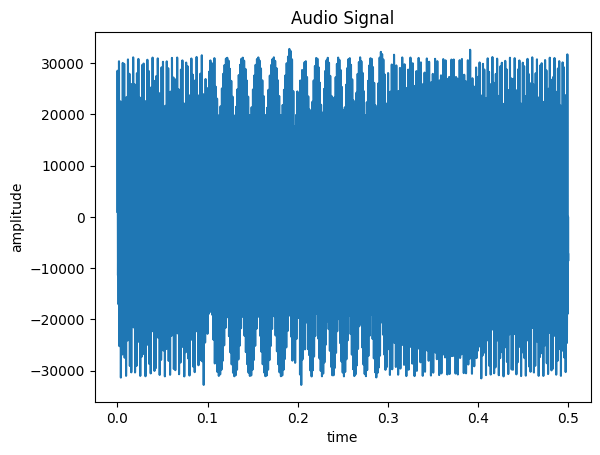

In [4]:
#Plotting the Audio Signal 
time = np.arange(len(data))/sample_rate
plt.plot(time,data)
plt.title('Audio Signal')
plt.xlabel('time')
plt.ylabel('amplitude')

In [46]:
n_qubits = math.ceil(np.log2(N))
data.extend([0] * (2**n_qubits-N))
data = data[:2**n_qubits]

Text(0, 0.5, 'amplitude')

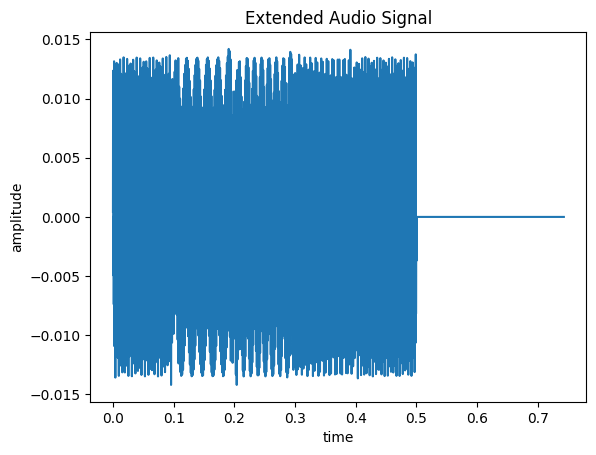

In [76]:
#Extending the data to make N=2**n where n is number of qubits used to encode the audio in a quantum circuit

n_qubits = math.ceil(np.log2(N))
data.extend([0] * (2**n_qubits-N))
data = data[:2**n_qubits]
data = data/np.linalg.norm(data)    #Normalizing the data array
N = len(data)                       #New length of the data

#Plotting the new extended audio signal
time = np.arange(N)/sample_rate
plt.plot(time,data)
plt.title('Extended Audio Signal')
plt.xlabel('time')
plt.ylabel('amplitude')

## Quantum Fourier Transform

In [6]:
#Defining qft algorithm
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    """Swapping the qubits as Qiskit uses little-endian notation (i.e., the last qubit is circuit is the most signficant bit)"""
    swap_registers(circuit, n)
    return circuit

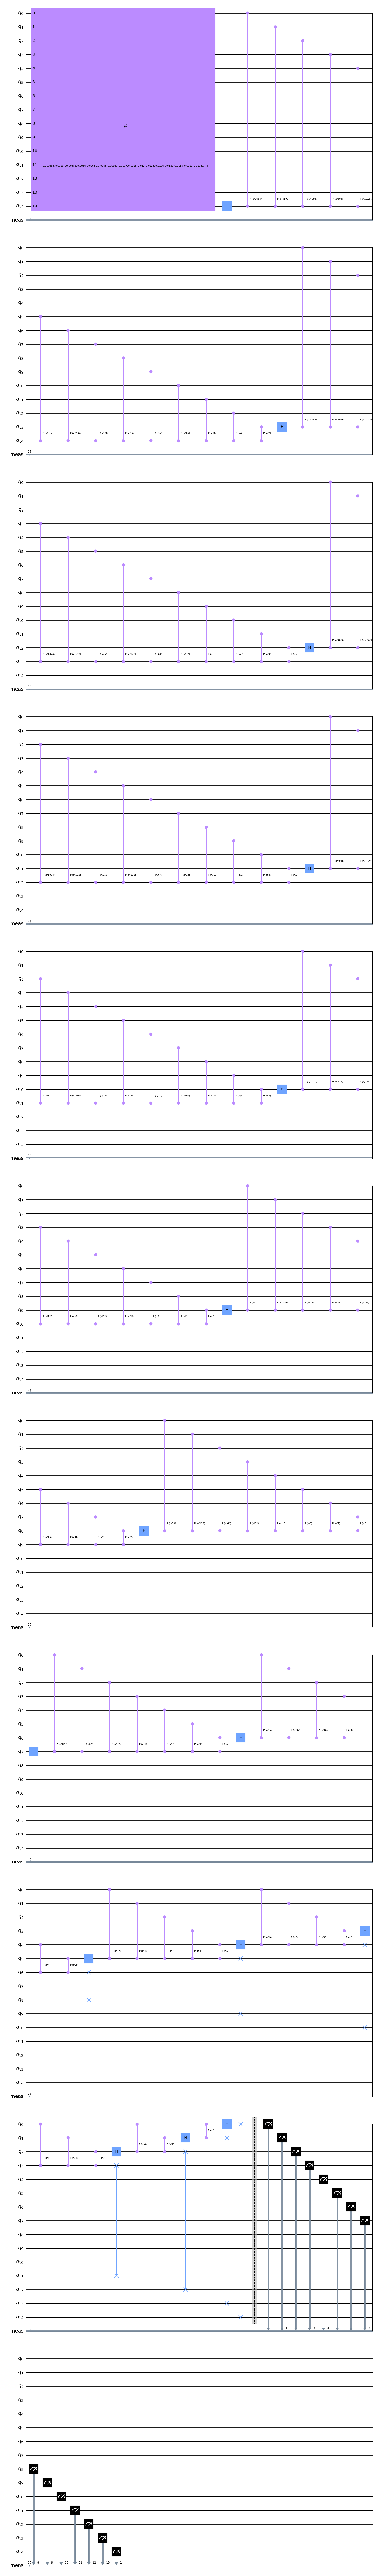

In [7]:
#Encoding the data array on the quantum circuit by using 'qpam' method - which takes the input data, normalizes it and initializes on circuit of n qubits

qc = QuantumCircuit(n_qubits)
qc.initialize(data,list(range(n_qubits)))

#Creating a circuit with quantum fourier transform alogithm
qft_circuit = qft(n_qubits)

#Merging both the initialized circuit and qft circuit
circuit = qc.compose(qft_circuit,list(range(n_qubits)))

#Measuring the qubits to get the classical results
circuit.measure_all()
circuit.draw('mpl')

In [8]:
#Using my IBM Quantum Experience account to access the quantum simulator online
from qiskit_ibm_runtime import Estimator, QiskitRuntimeService, Sampler, Session, Options

service = QiskitRuntimeService(
     channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='84e47768480771b0f65f16b3f25447e5ab6b88d174cccb8271d1d0a3e4fdf3ce875e7f9f2612ad64f6f107644f49d8c6d9cd2619469de103753b4ae7556e703a'
)
backend = service.backend('ibmq_qasm_simulator')  #A particular quantum simulator to run my circuit and get results

In [9]:
#Executing the circuit in the chosen backend
options = Options()
options.execution.shots = 10000       #Since we get the results probabilistically, we choose it run the same circuit multiple times.
sampler = Sampler(options=options,backend=backend)
job = sampler.run(circuit)            #Submitting the job to the backend
result = job.result()                 #Extracting the results from the job once it is executed successfully

In [ ]:
job = service.job('cm089up054sir2bvkhm0')
result = job.result()

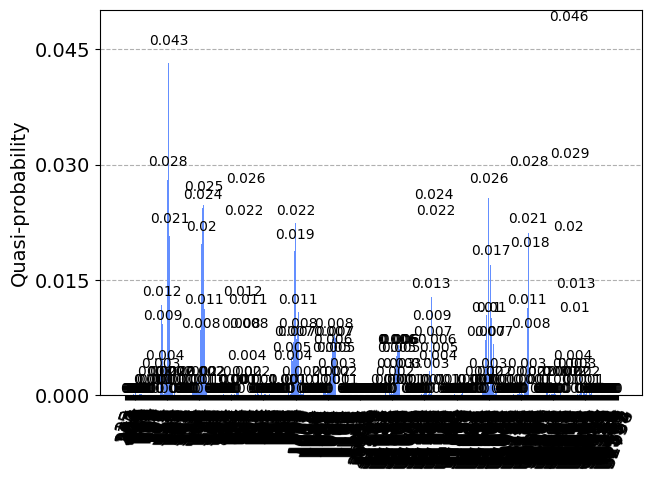

In [10]:
#plotting the probability histogram obtained (in this case this is the absolute value of fourier coefficients)
counts = result.quasi_dists          
plot_histogram(counts)         

In [11]:
#Defining the function to arange the counts got in ascending order and getting the corresponding probability (i.e., np.abs(fft)).
def get_fft_from_counts(counts,n_qubits):
    fft = []
    keys = counts.keys()
    for i in range(2**n_qubits):
        if i in keys:
            fft.append(counts[i])
        else:
            fft.append(0)
    return fft

In [66]:
qft = get_fft_from_counts(counts[0],n_qubits)
qft  = [i*len(data) for i in qft]

## Classical Fourier Transform

In [16]:
#Obtaining Fourier spectrum classically
fft = np.fft.fft(data)
N = len(fft)
freq = np.arange(N)*sample_rate/N

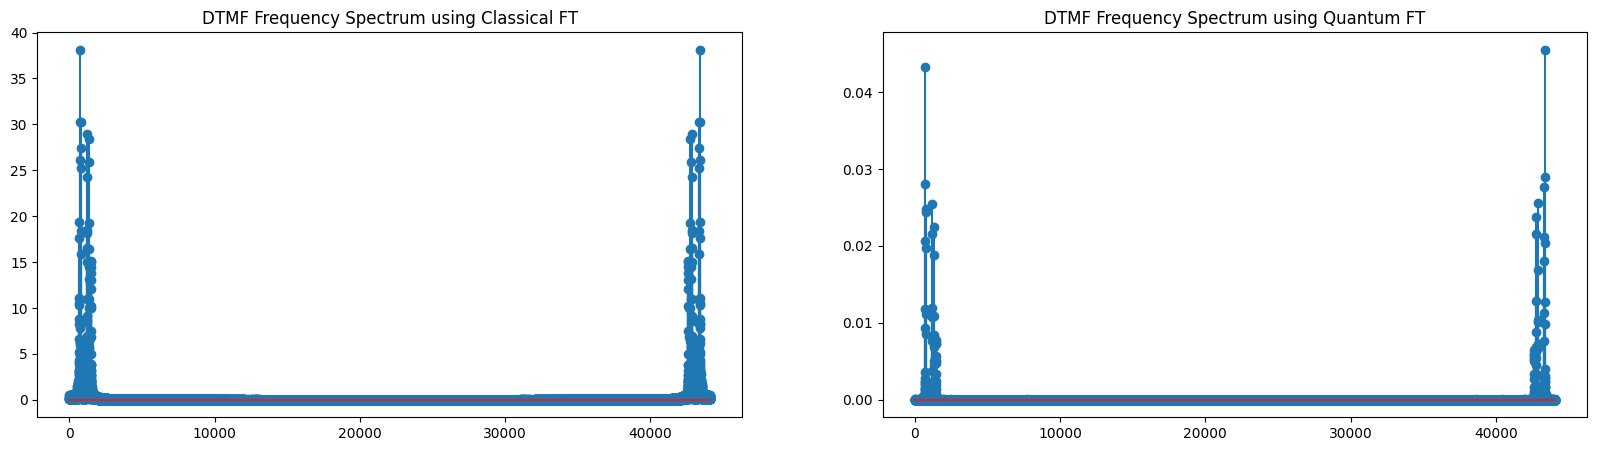

In [17]:
#Comparing Fourier spectrum from both
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.stem(freq,np.abs(fft))
plt.title('DTMF Frequency Spectrum using Classical FT')

plt.subplot(1,2,2)
plt.stem(freq,np.sqrt(qft))
plt.title('DTMF Frequency Spectrum using Quantum FT')

plt.subplots_adjust(wspace=0.2)

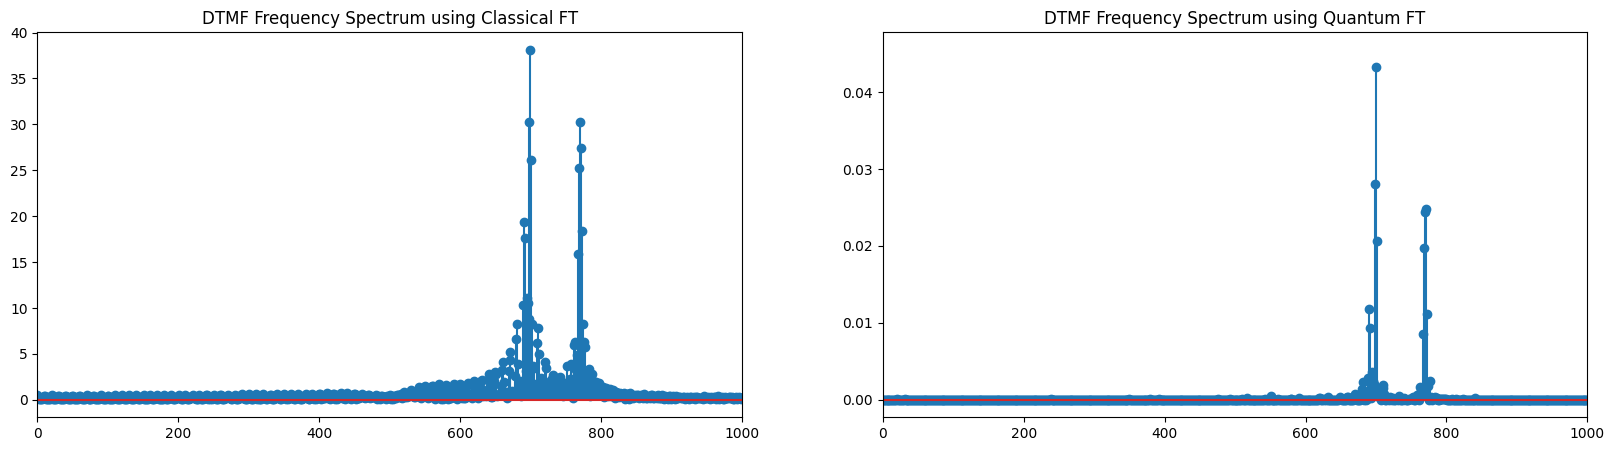

In [89]:
#Comparing Fourier spectrum from both
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.stem(freq,np.abs(fft))
plt.title('DTMF Frequency Spectrum using Classical FT')
plt.xlim(0,1000)

plt.subplot(1,2,2)
plt.stem(freq,qft)
plt.title('DTMF Frequency Spectrum using Quantum FT')
plt.xlim(0,1000)

plt.subplots_adjust(wspace=0.2)

In [65]:
abs_fft = [np.abs(i) for i in fft[:int(len(fft)/2)]]
abs_qft = [i for i in qft[:int(len(fft)/2)]]
#Finding the top 4 frequencies from both

indices_of_max_values_qft = np.argsort(abs_qft)[-4:][::-1]
indices_of_max_values_fft = np.argsort(abs_fft)[-4:][::-1]
qft_max = [freq[i] for i in indices_of_max_values_qft]
fft_max = [freq[i] for i in indices_of_max_values_fft]
print('Max 4 frequencies of the audio obtained using the Quantum FT is',qft_max)
print('Max 4 frequencies of the audio obtained using the Classical FT is',fft_max)

Max 4 frequencies of the audio obtained using the Quantum FT is [699.8291015625, 698.4832763671875, 1209.8968505859375, 771.1578369140625]
Max 4 frequencies of the audio obtained using the Classical FT is [699.8291015625, 769.81201171875, 698.4832763671875, 1209.8968505859375]


In [83]:
#Calculating power spectrum
power_spectrum_classical = [np.abs(i)**2 for i in fft]

total_power_classical = np.sum(power_spectrum_classical)
total_power_quantum = np.sum(qft)*len(data)
print('Total power of the audio obtained using the Quantum FT is',total_power_quantum)
print('Total power of the audio obtained using the Classical FT is',total_power_classical)

Total power of the audio obtained using the Quantum FT is 32768.0
Total power of the audio obtained using the Classical FT is 32767.999999999993
